# Fitting parametrisation models

## subgrid tendency = function(resolved tendency)
Motivated by our exploratory analysis, we choose a model of the form
$$
    (\text{subgrid tendency}) = f(z) \cdot (\text{resolved tendency})
$$
that is linear in the resolved tendency, where 
$$
    f(z) = \beta_0 + \beta_1 (z - 1/2)^2 + \beta_2 (z - 1/2)^4 + \ldots + \beta_N (z - 1/2)^{2N}
$$
is chosen in order to enforce the observed symmetry about $z=1/2$.

The model is fitted using OLS.

In [116]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import scipy as sp
import statsmodels.api as sm
import xarray as xr

import modules.parametrisation as param

In [2]:
fine_t = xr.open_mfdataset('../data/training/2048x256_t/*.nc')
fine_tplusdt = xr.open_mfdataset('../data/training/2048x256_tplusdt/*.nc')
fine_tend_filt = xr.open_dataset(
    '../data/training/2048x256_tend_256x64/2048x256_tend_256x64.nc')
coarse_t = xr.open_mfdataset(
    '../data/training/256x64_from_2048x256_diffused_t/*.nc')
coarse_tplusdt = xr.open_mfdataset(
    '../data/training/256x64_from_2048x256_diffused_tplusdt/*.nc')

fine_t = fine_t.isel(t=(fine_t.t < 299))
fine_tplusdt = fine_tplusdt.isel(t=(fine_tplusdt.t < 299))
coarse_t = coarse_t.isel(t=(coarse_t.t < 299))
coarse_tplusdt = coarse_tplusdt.isel(t=(coarse_tplusdt.t < 299))

fine_tend = param.tendency(fine_t, fine_tplusdt)
coarse_tend = param.tendency(coarse_t, coarse_tplusdt)
subgrid_tend = fine_tend_filt - coarse_tend

In [3]:
rng = np.random.default_rng(seed=0)
x_sample = rng.uniform(0, 8, 256*64)
z_sample = rng.uniform(0, 1, 256*64)

In [85]:
def predict(result, res_tend, z, max_n):
    x = np.column_stack([
        (z - 1/2)**(2*n) * res_tend
        for n in range(max_n + 1)
    ])
    x = sm.add_constant(x)
    return result.predict(x)

### Model for $\theta$

In [106]:
sub_tend_data = param.sample(
    subgrid_tend.theta.compute(), x_sample, z_sample, 0, 0)
res_tend_data = param.sample(
    coarse_tend.theta.compute(), x_sample, z_sample, 0, 0)

In [107]:
max_n = 10
regressors = np.column_stack([
    (np.atleast_2d((z_sample - 1/2)**(2*n)).T * res_tend_data).ravel()
    for n in range(max_n + 1)
])
regressors = sm.add_constant(regressors)
model = sm.OLS(sub_tend_data.ravel(), regressors)
theta_results = model.fit()
print(theta_results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                 4.498e+05
Date:                Thu, 05 Oct 2023   Prob (F-statistic):               0.00
Time:                        16:10:15   Log-Likelihood:             3.6867e+06
No. Observations:             1638400   AIC:                        -7.373e+06
Df Residuals:                 1638388   BIC:                        -7.373e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.787e-05   1.99e-05      0.897      0.3

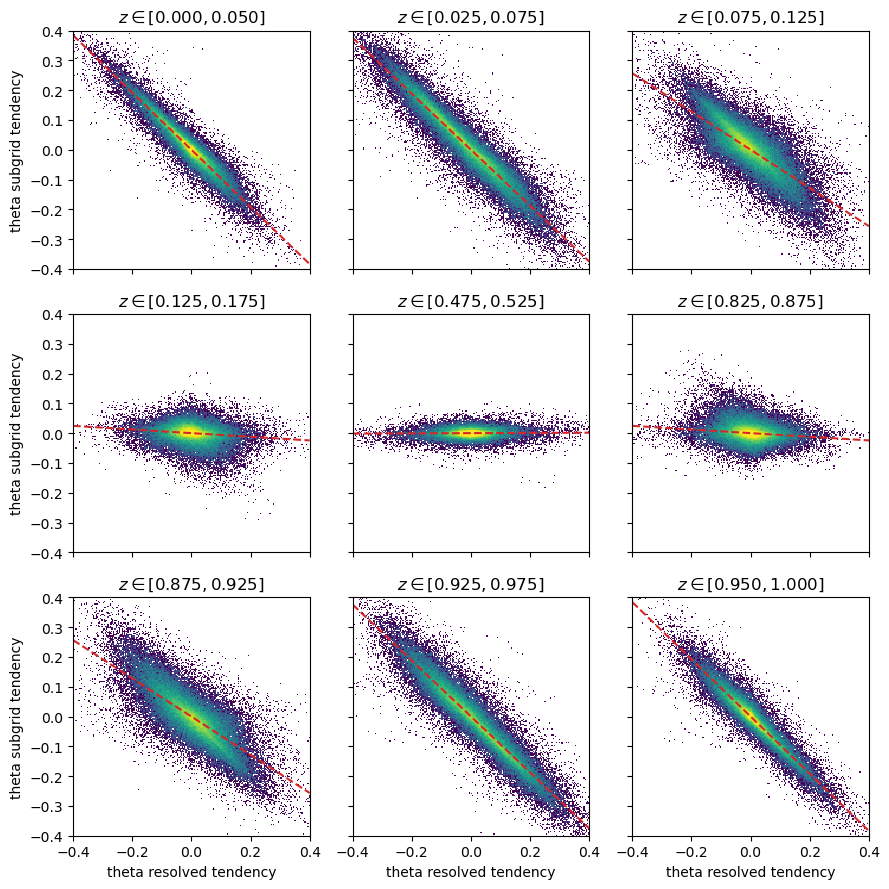

In [108]:
n_rows, n_cols = 3, 3
z_slices = [0.025, 0.05, 0.1, 0.15, 0.5, 0.85, 0.9, 0.95, 0.975]
z_tol = 0.025
x_range = [-0.4, 0.4]
x_predict = np.linspace(*x_range, 10)

fig, axes = plt.subplots(
    n_rows, n_cols, figsize=(9, 9), sharex=True, sharey=True)
for i, ax in enumerate(axes.ravel()):
    z_min = z_slices[i] - z_tol
    z_max = z_slices[i] + z_tol
    mask = (z_min <= z_sample) & (z_sample <= z_max)

    ax.hist2d(
        res_tend_data[mask,:].ravel(), sub_tend_data[mask,:].ravel(),
        bins=[200, 200], range=[x_range, [-0.4, 0.4]],
        norm='log', vmin=1, vmax=200,
    )

    prediction = predict(theta_results, x_predict, z_slices[i], max_n)
    ax.plot(x_predict, prediction, color='tab:red', linestyle='--')
    ax.set(title=f'$z \\in [{z_min:.3f}, {z_max:.3f}]$')

for i in range(n_rows):
    axes[i,0].set_ylabel('theta subgrid tendency')
for i in range(n_cols):
    axes[-1,i].set_xlabel('theta resolved tendency')

fig.tight_layout()

### Model for $u$

In [109]:
sub_tend_data = param.sample(
    subgrid_tend.u.compute(), x_sample, z_sample, 0, 0)
res_tend_data = param.sample(
    coarse_tend.u.compute(), x_sample, z_sample, 0, 0)

In [110]:
max_n = 10
regressors = np.column_stack([
    (np.atleast_2d((z_sample - 1/2)**(2*n)).T * res_tend_data).ravel()
    for n in range(max_n + 1)
])
regressors = sm.add_constant(regressors)
model = sm.OLS(sub_tend_data.ravel(), regressors)
u_results = model.fit()
print(u_results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.325
Model:                            OLS   Adj. R-squared:                  0.325
Method:                 Least Squares   F-statistic:                 7.184e+04
Date:                Thu, 05 Oct 2023   Prob (F-statistic):               0.00
Time:                        16:10:47   Log-Likelihood:             2.2576e+06
No. Observations:             1638400   AIC:                        -4.515e+06
Df Residuals:                 1638388   BIC:                        -4.515e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.662e-05   4.77e-05      1.818      0.0

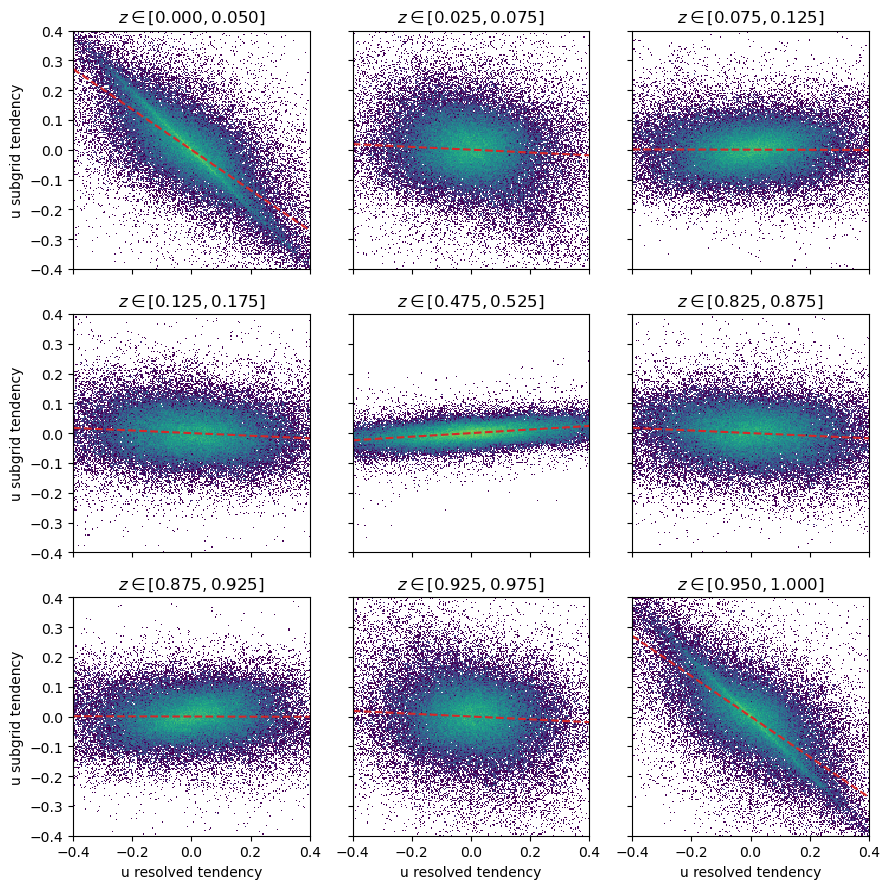

In [111]:
n_rows, n_cols = 3, 3
z_slices = [0.025, 0.05, 0.1, 0.15, 0.5, 0.85, 0.9, 0.95, 0.975]
z_tol = 0.025
x_range = [-0.4, 0.4]
x_predict = np.linspace(*x_range, 10)

fig, axes = plt.subplots(
    n_rows, n_cols, figsize=(9, 9), sharex=True, sharey=True)
for i, ax in enumerate(axes.ravel()):
    z_min = z_slices[i] - z_tol
    z_max = z_slices[i] + z_tol
    mask = (z_min <= z_sample) & (z_sample <= z_max)

    ax.hist2d(
        res_tend_data[mask,:].ravel(), sub_tend_data[mask,:].ravel(),
        bins=[200, 200], range=[x_range, [-0.4, 0.4]],
        norm='log', vmin=1, vmax=200,
    )

    prediction = predict(u_results, x_predict, z_slices[i], max_n)
    ax.plot(x_predict, prediction, color='tab:red', linestyle='--')
    ax.set(title=f'$z \\in [{z_min:.3f}, {z_max:.3f}]$')

for i in range(n_rows):
    axes[i,0].set_ylabel('u subgrid tendency')
for i in range(n_cols):
    axes[-1,i].set_xlabel('u resolved tendency')

fig.tight_layout()

### Model for $w$

In [112]:
sub_tend_data = param.sample(
    subgrid_tend.w.compute(), x_sample, z_sample, 0, 0)
res_tend_data = param.sample(
    coarse_tend.w.compute(), x_sample, z_sample, 0, 0)

In [113]:
max_n = 10
regressors = np.column_stack([
    (np.atleast_2d((z_sample - 1/2)**(2*n)).T * res_tend_data).ravel()
    for n in range(max_n + 1)
])
regressors = sm.add_constant(regressors)
model = sm.OLS(sub_tend_data.ravel(), regressors)
w_results = model.fit()
print(w_results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                 1.080e+04
Date:                Thu, 05 Oct 2023   Prob (F-statistic):               0.00
Time:                        16:11:29   Log-Likelihood:             2.6061e+06
No. Observations:             1638400   AIC:                        -5.212e+06
Df Residuals:                 1638388   BIC:                        -5.212e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.036e-05   3.85e-05     -0.528      0.5

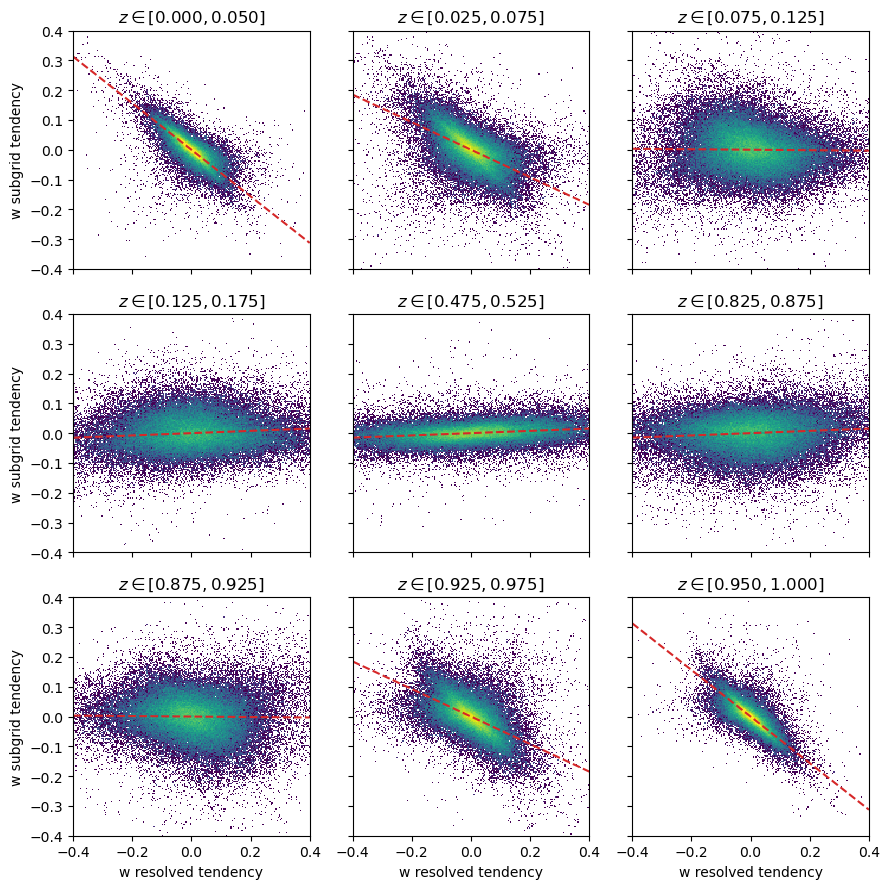

In [114]:
n_rows, n_cols = 3, 3
z_slices = [0.025, 0.05, 0.1, 0.15, 0.5, 0.85, 0.9, 0.95, 0.975]
z_tol = 0.025
x_range = [-0.4, 0.4]
x_predict = np.linspace(*x_range, 10)

fig, axes = plt.subplots(
    n_rows, n_cols, figsize=(9, 9), sharex=True, sharey=True)
for i, ax in enumerate(axes.ravel()):
    z_min = z_slices[i] - z_tol
    z_max = z_slices[i] + z_tol
    mask = (z_min <= z_sample) & (z_sample <= z_max)

    ax.hist2d(
        res_tend_data[mask,:].ravel(), sub_tend_data[mask,:].ravel(),
        bins=[200, 200], range=[x_range, [-0.4, 0.4]],
        norm='log', vmin=1, vmax=200,
    )

    prediction = predict(w_results, x_predict, z_slices[i], max_n)
    ax.plot(x_predict, prediction, color='tab:red', linestyle='--')
    ax.set(title=f'$z \\in [{z_min:.3f}, {z_max:.3f}]$')

for i in range(n_rows):
    axes[i,0].set_ylabel('w subgrid tendency')
for i in range(n_cols):
    axes[-1,i].set_xlabel('w resolved tendency')

fig.tight_layout()

### Output to csv

In [127]:
params = pd.DataFrame({
    'theta': theta_results.params,
    'u': u_results.params,
    'w': w_results.params,
})
params.to_csv('../data/training/256x64_params.csv', index=False)
params

,theta,u,w
0,1.787142e-05,8.662128e-05,-2.035647e-05
1,3.628076e-03,6.006067e-02,3.803475e-02
2,8.112863e+00,2.621805e+00,5.174562e-01
3,-1.342946e+03,-6.200252e+02,-1.545266e+02
4,7.565791e+04,4.234961e+04,8.697679e+03
5,-2.085485e+06,-1.373401e+06,-2.502676e+05
6,3.199009e+07,2.470205e+07,4.277322e+06
7,-2.893049e+08,-2.638605e+08,-4.543247e+07
8,1.567177e+09,1.706737e+09,3.018044e+08
9,-4.965491e+09,-6.537167e+09,-1.214850e+09
